# Outlier and Anomaly Detection

___`Exploratory Risk Assessment notebook`___

# Objective
This notebook performs __systematic outlier and anomaly detection__ to:
- Identify extreme and rare observations

- Distinguish noise from business-critical signals

- Quantify modeling and operational risk

- Decide - `what to keep, transform, cap, or isolate`

This notebook anwers:

___`Which observations can materially distort analysis, models, or decisions?`___


## Why Outlier & Anomaly is a Risk Exercise
Outliers are not just statistical artifacts. They may represent:

- Fraud or abuse

- VIP or high-value customers

- System failures or data corruption

- Edge cases driving revenue or loss

Incorrect handling leads to:

- Biased models

- Fragile performance

- Regulatory exposure



## Imports and Configuration

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# Step 1 – Load Dataset

We reuse the same dataset from previous EDA notebooks for continuity.

In [4]:
np.random.seed(2010)

N = 5000

df = pd.DataFrame({
    "age": np.random.randint(18, 75, size=N),
    "income": np.random.lognormal(mean=10.8, sigma=0.6, size=N),
    "tenure_years": np.random.exponential(scale=6, size=N),
    "transactions_last_30d": np.random.poisson(lam=4, size=N),
    "region": np.random.choice(
        ["North", "South", "East", "West"],
        size=N,
        p=[0.35, 0.25, 0.25, 0.15]
    ),
    "churn": np.random.binomial(1, 0.28, size=N)
})

df.head()


,age,income,tenure_years,transactions_last_30d,region,churn
0,18,45868.374647,5.749047,4,North,0
1,18,74287.388492,1.537824,5,South,0
2,67,78586.352313,24.502748,3,North,0
3,64,56102.925430,1.502888,3,South,0
4,37,25639.985952,3.950600,6,North,0


# Step 2 – Univariate Statistical Outliers
2.1 IQR Method

In [5]:
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)


In [6]:
outlier_flags = pd.DataFrame({
    col: iqr_outliers(df[col])
    for col in ["income", "tenure_years", "transactions_last_30d"]
})

outlier_flags.mean()


income                   0.0470
tenure_years             0.0498
transactions_last_30d    0.0230
dtype: float64

### Interpretation

- Income and tenure naturally produce many IQR outliers

- IQR alone is not sufficient for business decisions

## Visualization

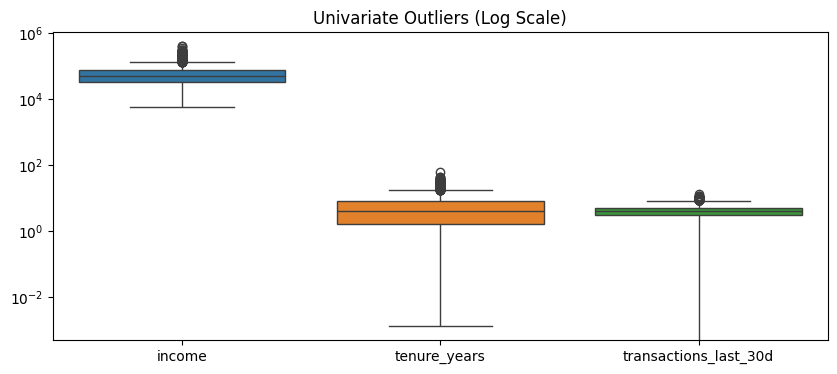

In [10]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df[["income", "tenure_years", "transactions_last_30d"]])
plt.yscale("log")
plt.title("Univariate Outliers (Log Scale)")
plt.show()


# Step 3 – Z-Score Analysis (Risky by Design)

In [17]:
z_scores = (
    (df[["income", "tenure_years"]] -
     df[["income", "tenure_years"]].mean())
    / df[["income", "tenure_years"]].std()
)

(z_scores.abs() > 3).mean()


income          0.0170
tenure_years    0.0172
dtype: float64

## Risk Note

- Z-scores assume normality

- Heavy-tailed variables violate assumptions

- Useful only as rough indicators

## Interpretation

- ~1.7% of observations in income are extreme outliers

- ~1.7% of observations in tenure_years are extreme outliers

These are values more than 3 standard deviations from the mean

### Statistically correct conclusion

    Both income and tenure_years contain a small proportion (~1.7%) of extreme outliers, indicating mild but non-negligible tail behavior.

Or we simply can say:

    Most customers have typical income and tenure values, but a small fraction have unusually high or low values.
    
### Is this “a lot” of outliers?

- In a perfect normal distribution, you’d expect ~0.3%

- You’re seeing ~1.7%, which suggests:

    - Slight skewness or heavy tails

    - Possibly real high-income or long-tenure customers (not data errors)

So this is not alarming, but it is worth acknowledging.

### What this implies for modeling

- Linear regression can be influenced by these outliers

- Tree-based models won’t care much

- Scaling won’t fix outliers—it just rescales them

### Sensible next steps (optional)

- Winsorize or cap extreme values

- Use __robust regression__ (e.g. Tree-based models)

- Log-transform income:

In [19]:
log_income = np.log(df["income"])

### An example of one line for report
_`Approximately 1.7% of observations in income and tenure_years exceed three standard deviations from the mean, indicating the presence of mild extreme values but no widespread outlier issue.`_

# Step 4 – Multivariate Anomaly Detection
## Feature Scaling

In [18]:
features = [
    "age",
    "income",
    "tenure_years",
    "transactions_last_30d"
]

X_scaled = StandardScaler().fit_transform(df[features])


## Isolation Forest

In [27]:
iso = IsolationForest(
    contamination=0.03,
    random_state=2010
)

df["iso_anomaly"] = iso.fit_predict(X_scaled)


In [28]:
df["iso_anomaly"].value_counts(normalize=True)

iso_anomaly
 1    0.97
-1    0.03
Name: proportion, dtype: float64

## Visualization (PCA Projection)

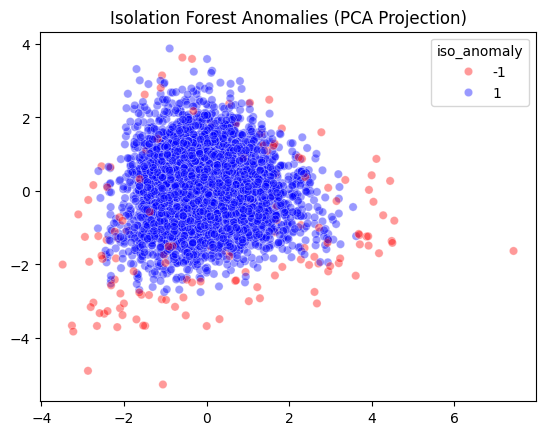

In [29]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure()
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df["iso_anomaly"],
    palette={1: "blue", -1: "red"},
    alpha=0.4
)
plt.title("Isolation Forest Anomalies (PCA Projection)")
plt.show()


# Step 5 – Local Outlier Factor (Density-Based)

In [30]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.03
)

df["lof_anomaly"] = lof.fit_predict(X_scaled)


In [31]:
df["lof_anomaly"].value_counts(normalize=True)


lof_anomaly
 1    0.97
-1    0.03
Name: proportion, dtype: float64

## Insight

LOF detects local density anomalies

- Isolation Forest detects global isolation


- Overlap is informative


# Step 6 – Anomalies vs Target (Business Impact)

In [32]:
df.groupby("iso_anomaly")["churn"].mean()


iso_anomaly
-1    0.253333
 1    0.277113
Name: churn, dtype: float64

In [33]:
df.groupby("lof_anomaly")["churn"].mean()

lof_anomaly
-1    0.30000
 1    0.27567
Name: churn, dtype: float64

# Step 7 – Risk Assessment Matrix

## Outlier Handling Is a Decision Problem



| Scenario            | Risk                    |
| ------------------- | ----------------------- |
| Remove all outliers | Signal loss             |
| Ignore anomalies    | Model instability       |
| Cap blindly         | Distorted relationships |
| Segment anomalies   | Controlled risk         |
| Separate modeling   | Advanced maturity       |


# Step 9 – What This Notebook Feeds Into

Outputs from this notebook inform:

- Preprocessing strategy (capping, scaling, robust loss)

- Feature engineering (flags, buckets)

- Model choice (tree vs linear vs robust)

- Monitoring rules in production

Next logical step:

    02_Data_Preprocessing/
    └── 02_outlier_treatment_strategies.ipynb


## Summary

This notebook demonstrated:

- Statistical vs ML-based anomaly detection

- Univariate vs multivariate outliers

- Density vs isolation concepts

- Explicit risk-based interpretation

Outliers are not noise by default.

They are risk signals.